In [1]:
import numpy as np
import scipy 

Text to explain something

$ x^2+5=0 $


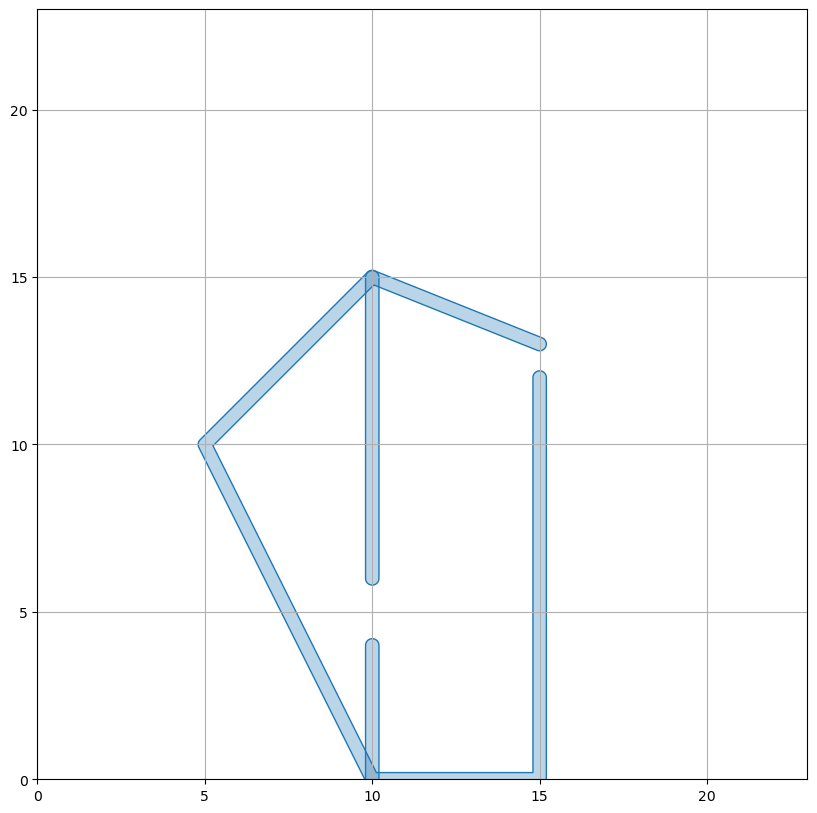

In [2]:
import matplotlib.pyplot as plt

from shapely.geometry import Point, Polygon, LineString
from shapely import plotting

MedField1 = dict()
MedField1["obs1"] = LineString([(15,13), (10,15), (5,10), (10,0), (15,0), (15,12) ]).buffer(0.2)
MedField1["obs2"] = LineString([(10,0), (10,4) ]).buffer(0.2)
MedField1["obs3"] = LineString([(10,15), (10,6) ]).buffer(0.2)

def drawScene(content, limits=[[0,23],[0,23]], figsize=(10,10)):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(1,1,1)
    ax.set_xlim(limits[0])
    ax.set_ylim(limits[1])
    for key, value in content.items():
        plotting.plot_polygon(value, add_points=False)
        

drawScene(MedField1, figsize=(10,10))


----------- Benchmark Results -----------
Number of nodes: 162
Number of edges: 995
Collision checks performed: 1292
Path found with length: 103.48
Planning time: 0.88 seconds
------------------------------------------


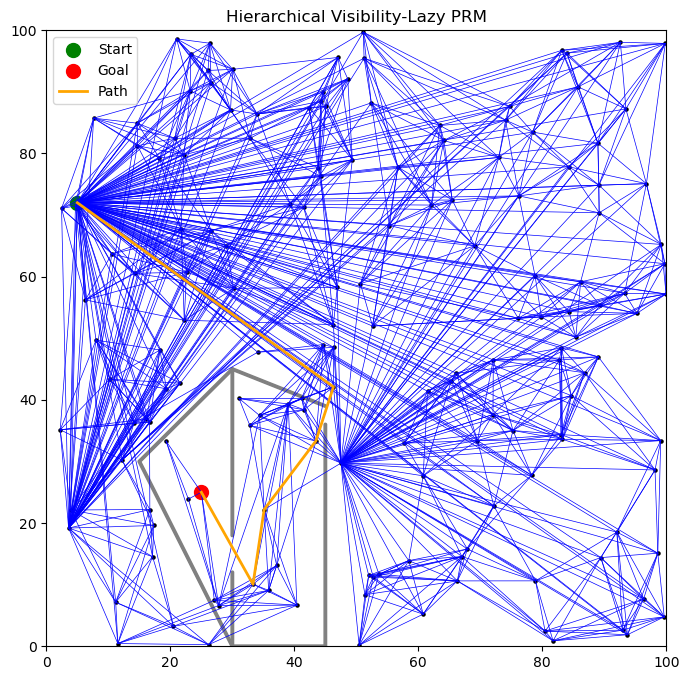

In [5]:
import networkx as nx
import random
import numpy as np
import math
import matplotlib.pyplot as plt
import time
from shapely.geometry import Point, Polygon, LineString


# ---------- CONFIGURATION ----------
map_bounds = (0, 100, 0, 100)

obstacles = [
    LineString([(45, 39), (30, 45), (15, 30), (30, 0), (45, 0), (45, 36)]).buffer(0.2),
    LineString([(30, 0), (30, 12)]).buffer(0.2),
    LineString([(30, 45), (30, 18)]).buffer(0.2)
]

num_regions = 4
samples_per_region = 40
lazy_k_neighbors = 8


# ---------- COLLISION COUNTER ----------
collision_checks = 0


def is_collision(p1, p2, obstacles):
    """Check if the line between p1 and p2 collides with any obstacle."""
    global collision_checks
    collision_checks += 1

    line = LineString([p1, p2])
    for obs in obstacles:
        if line.crosses(obs) or line.within(obs):
            return True
    return False


def sample_free(bounds, obstacles):
    """Sample a collision-free point."""
    minx, maxx, miny, maxy = bounds
    while True:
        x = random.uniform(minx, maxx)
        y = random.uniform(miny, maxy)
        point = Point(x, y)
        if not any(obs.contains(point) for obs in obstacles):
            return (x, y)


# ---------- LAZY PRM ----------
def build_lazy_prm(region_bounds, num_samples, k, obstacles):
    G = nx.Graph()
    nodes = []

    for _ in range(num_samples):
        node = sample_free(region_bounds, obstacles)
        G.add_node(node)
        nodes.append(node)

    for node in nodes:
        distances = [(other, np.linalg.norm(np.subtract(node, other)))
                     for other in nodes if other != node]
        distances.sort(key=lambda x: x[1])
        neighbors = distances[:k]

        for neighbor, dist in neighbors:
            G.add_edge(node, neighbor, weight=dist)

    return G


# ---------- VISIBILITY PRM ----------
def build_visibility_prm(nodes, obstacles):
    G = nx.Graph()
    for node in nodes:
        G.add_node(node)

        for other in G.nodes:
            if other == node:
                continue

            try:
                _ = nx.shortest_path(G, source=node, target=other)
                continue
            except nx.NetworkXNoPath:
                pass

            if not is_collision(node, other, obstacles):
                dist = np.linalg.norm(np.subtract(node, other))
                G.add_edge(node, other, weight=dist)

    return G


# ---------- HIERARCHICAL PRM ----------
def build_hierarchical_visibility_lazy_prm(global_bounds, num_regions, samples_per_region, k, obstacles):
    minx, maxx, miny, maxy = global_bounds
    midx = (minx + maxx) / 2
    midy = (miny + maxy) / 2

    regions = [
        (minx, midx, miny, midy),  # Bottom-left
        (midx, maxx, miny, midy),  # Bottom-right
        (minx, midx, midy, maxy),  # Top-left
        (midx, maxx, midy, maxy)   # Top-right
    ]

    local_graphs = []
    all_nodes = []

    for region in regions:
        local_graph = build_lazy_prm(region, samples_per_region, k, obstacles)
        local_graphs.append(local_graph)
        all_nodes.extend(local_graph.nodes)

    global_graph = build_visibility_prm(all_nodes, obstacles)

    for local in local_graphs:
        global_graph.add_edges_from(local.edges(data=True))

    return global_graph


# ---------- LAZY VALIDATION ----------
def validate_lazy_path(G, path, obstacles):
    valid = True
    for u, v in zip(path[:-1], path[1:]):
        if is_collision(u, v, obstacles):
            G.remove_edge(u, v)
            valid = False
    return valid


def lazy_shortest_path(G, start, goal, obstacles):
    while True:
        try:
            path = nx.shortest_path(G, source=start, target=goal, weight='weight')
        except nx.NetworkXNoPath:
            return None

        if validate_lazy_path(G, path, obstacles):
            return path


# ---------- PLOTTING ----------
def plot_prm(G, obstacles, start=None, goal=None, path=None):
    plt.figure(figsize=(8, 8))

    # Plot obstacles
    for obs in obstacles:
        x, y = obs.exterior.xy
        plt.fill(x, y, color='gray')

    # Plot edges
    for (u, v) in G.edges:
        x = [u[0], v[0]]
        y = [u[1], v[1]]
        plt.plot(x, y, color='blue', linewidth=0.5)

    # Plot nodes
    xs, ys = zip(*G.nodes)
    plt.scatter(xs, ys, color='black', s=5)

    # Plot start and goal
    if start:
        plt.scatter(start[0], start[1], color='green', s=100, label="Start")
    if goal:
        plt.scatter(goal[0], goal[1], color='red', s=100, label="Goal")

    # Plot path
    if path:
        px, py = zip(*path)
        plt.plot(px, py, color='orange', linewidth=2, label="Path")

    plt.xlim(map_bounds[0], map_bounds[1])
    plt.ylim(map_bounds[2], map_bounds[3])
    plt.legend()
    plt.title("Hierarchical Visibility-Lazy PRM")
    plt.show()


# ---------- MAIN ----------
if __name__ == "__main__":
    start_time = time.time()

    collision_checks = 0  # Reset

    # Build graph
    G = build_hierarchical_visibility_lazy_prm(map_bounds, num_regions, samples_per_region, lazy_k_neighbors, obstacles)

    start = (5, 72)
    goal = (25, 25)

    G.add_node(start)
    G.add_node(goal)

    for node in G.nodes:
        if node == start or node == goal:
            continue
        if not is_collision(node, start, obstacles):
            dist = np.linalg.norm(np.subtract(node, start))
            G.add_edge(node, start, weight=dist)
        if not is_collision(node, goal, obstacles):
            dist = np.linalg.norm(np.subtract(node, goal))
            G.add_edge(node, goal, weight=dist)

    # Lazy search
    path = lazy_shortest_path(G, start, goal, obstacles)

    end_time = time.time()
    planning_time = end_time - start_time

    # Compute path length
    path_length = 0
    if path:
        for u, v in zip(path[:-1], path[1:]):
            path_length += np.linalg.norm(np.subtract(u, v))

    # ---------- BENCHMARK ----------
    print("\n----------- Benchmark Results -----------")
    print(f"Number of nodes: {G.number_of_nodes()}")
    print(f"Number of edges: {G.number_of_edges()}")
    print(f"Collision checks performed: {collision_checks}")
    if path:
        print(f"Path found with length: {path_length:.2f}")
    else:
        print("No valid path found.")
    print(f"Planning time: {planning_time:.2f} seconds")
    print("------------------------------------------")

    # ---------- PLOT ----------
    plot_prm(G, obstacles, start, goal, path)
